In [15]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from tqdm import tqdm
import matplotlib.animation as ani
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AR
import pmdarima as pm

In [2]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
plt.style.use('seaborn-dark-palette')
plt.rcParams["mathtext.fontset"] = "cm"

In [4]:
def all_data():
    data = pd.read_csv('../dataset/radar/radar_narr_combine.csv')
    # from "samplingperiod" to "ordinal.date", from radar dataset
    # from "year" to "visibility", from North American Regional Reanalysis (NARR) data
    print(data.info())
    print(data)
    columns = ['hgt.agl', 
           'uwind', 
           'vwind', 
           'air', 
           'pressure.sfc', 
           'relative.humidity', 
           'lon', 
           'lat', 
           'ordinal.date', 
           'omega', 
           'total.cloud.cover', 
           'visibility', 
           'albedo', 
           'acc.total.precip',
           'msl.pressure',
           'cape',
           'snow.cover']
    data.filtered = data[(data['clear'] > 0.7) & 
                         (data['uwind'] * data['uwind'] + data['vwind'] * data['vwind'] > 25)]
    data.filtered = data.filtered[columns]
    return data, data.filtered

# Correlation

In [7]:
#correlation.pearson = data.filtered.corr(method = "pearson")
def correlation_pearson(data, columns):
    correlation = data.corr(method = "pearson")
    plt.figure()
    sns.heatmap(data.corr(method = "pearson"), xticklabels = data.corr(method = "pearson").columns, 
                yticklabels = data.corr(method = "pearson").columns, cmap = 'RdYlGn', center = 0, annot = True)
    plt.title('Correlation pearson')
    plt.xticks(np.arange(len(columns))+0.5, columns) 
    plt.yticks(np.arange(len(columns))+0.5, columns) 
    plt.savefig('../figures/bird/correlation_pearson.png',dpi=300)
    plt.show()
    return correlation

def correlation_spearman(data, columns):
    correlation = data.corr(method = "spearman")
    plt.figure()
    sns.heatmap(data.corr(method = "spearman"), xticklabels = data.corr(method = "spearman").columns, 
                yticklabels = data.corr(method = "spearman").columns, cmap = 'RdYlGn', center = 0, annot = True)
    plt.title('Correlation Spearman')
    plt.xticks(np.arange(len(columns))+0.5, columns) 
    plt.yticks(np.arange(len(columns))+0.5, columns) 
    plt.savefig('../figures/bird/correlation_spearman.png',dpi=300)
    plt.show()
    return correlation

In [ ]:
data, data.filtered = all_data()
columns = data.columns
cor_pearson = correlation_pearson(data, columns)
cor_spearman = correlation_spearman(data, columns)

In [27]:
# print all the columns
pd.set_option('display.max_columns', None)
# print all the lines
pd.set_option('display.max_rows', None)

# Density per latitude and per longitude

In [7]:
def density_data(data):
    columns = ['samplingperiod', 
               'radar_id', 
               'lon', 
               'lat', 
               'hgt.agl', 
               'linear_eta']
    data.density = data[columns]
    data.density['linear_eta'] = data.density['linear_eta']/11
    data.density.to_csv('../dataset/radar/density.csv', index = False)
    return data.density

def drop_altitude(data):
    df = data.drop_duplicates(subset = ['lon', 'lat', 'samplingperiod'], keep = 'first')
    df = df[['samplingperiod', 'lat', 'lon', 'linear_eta', 'radar_id']]
    
    data['linear_eta'].astype('float')
    
    #print(data[(data['samplingperiod']==df.iloc[0, 0])&(data['lat']==df.iloc[0, 1])&(data['lon']==df.iloc[0, 2])][['linear_eta']].dtypes)
    for i in tqdm(range(len(df))):
        df.iloc[i, 3] = data[(data['samplingperiod']==df.iloc[i, 0])&(data['lat']==df.iloc[i, 1])&(data['lon']==df.iloc[i, 2])][['linear_eta']].values.sum()
    
    df.reset_index(inplace = True, drop = True)
    return df

def time_series_(data):
    time = pd.DataFrame(np.unique(data['samplingperiod']), columns = ['samplingperiod'])
    col = pd.DataFrame(np.zeros((len(time),)), columns = ['0'])
    time = pd.concat([time, col], axis = 1)
    time.set_index('samplingperiod', inplace = True)
    radars = np.unique(data['radar_id'])
    for radar in tqdm(radars):
        col = data[data['radar_id']==radar][['samplingperiod', 'linear_eta']]
        col.rename(columns = {'linear_eta':'%s'%radar}, inplace = True)
        col = pd.DataFrame(col)
        col.set_index('samplingperiod', inplace = True)
        time = pd.concat([time, col], axis = 1)
       
    time.drop(['0'], axis=1, inplace = True)

    return time

In [12]:
def map_plot(data, lat_min, lat_max, lon_min, lon_max):
    plt.figure()
    earth = Basemap(llcrnrlon=lon_min, llcrnrlat=lat_min, urcrnrlon=lon_max, urcrnrlat=lat_max)
    earth.drawcountries()
    earth.bluemarble(alpha=0.42)
    earth.drawcoastlines(color='#555566', linewidth=1)
    earth.scatter(data['lon'], data['lat'])
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    plt.savefig('../figures/bird/distribution.png', dpi=350)
    plt.show()
    
def line_plot(data, name):
    plt.figure()
    plt.plot(data.iloc[:,0], data.iloc[:,1], 'ro-', color = '#4169E1', alpha = 0.8, linewidth = 1, label = '%s'%name)
    plt.legend(loc="upper right")
    plt.xlabel('time')
    plt.ylabel('density of birds')
    plt.savefig('../figures/bird/line_%s.jpg'%name)
    plt.show()
    
def scatter_plot(data):
    plt.figure(figsize=(14, 8))
    data.plot.scatter('lon', 'lat', c='linear_eta', colormap = 'jet')
    plt.show()

In [9]:
data = pd.read_csv('../dataset/radar/density.csv')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7025340 entries, 0 to 7025339
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   samplingperiod  object 
 1   radar_id        object 
 2   lon             float64
 3   lat             float64
 4   hgt.agl         int64  
 5   linear_eta      float64
dtypes: float64(3), int64(1), object(2)
memory usage: 321.6+ MB
None


In [14]:
#data.drop_altitude = drop_altitude(data)
#data.drop_altitude.to_csv('../dataset/radar/density_drop_alt.csv', index = False)
data.drop_altitude = pd.read_csv('../dataset/radar/density_drop_alt.csv')

<ipython-input-14-3688a3aff51b>:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.drop_altitude = pd.read_csv('../dataset/radar/density_drop_alt.csv')


In [15]:
lat_min = min(data['lat'])
lat_max = max(data['lat'])
lon_min = min(data['lon'])
lon_max = max(data['lon'])
eta_min = min(data['linear_eta'])
eta_max = max(data['linear_eta'])
print(lat_min, lat_max, lon_min, lon_max, eta_min, eta_max)


24.5975 48.3925 -124.29194 -67.806389 0.0 3236.090909090909


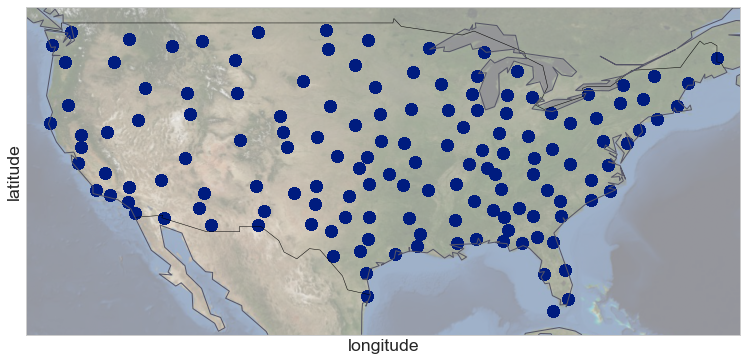

In [16]:
#scatter_plot(data.drop_altitude)
map_plot(data.drop_altitude, lat_min-2, lat_max+2, lon_min-2, lon_max+2)

In [17]:
time_series_(data.drop_altitude).to_csv('../dataset/radar/time_series.csv', index = True)

100%|██████████| 143/143 [00:02<00:00, 61.47it/s]


In [6]:
time_series = pd.read_csv('../dataset/radar/time_series.csv')
time_series

samplingperiod        KABR        KABX         KAKQ        KAMA  \
0        1995-03-01         NaN         NaN          NaN         NaN   
1        1995-03-02         NaN         NaN          NaN         NaN   
2        1995-03-03         NaN         NaN          NaN         NaN   
3        1995-03-04         NaN         NaN          NaN         NaN   
4        1995-03-05         NaN         NaN          NaN         NaN   
...             ...         ...         ...          ...         ...   
2110     2017-05-27  183.349949   43.851022   113.836589  261.597315   
2111     2017-05-28  128.136609   43.615912  2045.500742   27.877210   
2112     2017-05-29   45.435735  121.120333   100.937698   54.958877   
2113     2017-05-30   63.814922   65.480666  2892.995924  119.952136   
2114     2017-05-31  162.604766   86.117620   157.995229  106.987176   

           KAMX        KAPX         KARX        KATX        KBBX  ...  \
0           NaN         NaN          NaN         NaN         NaN  ...   
1           NaN         NaN          NaN         NaN         NaN  ...   
2           NaN         NaN          NaN         NaN         NaN  ...   
3           NaN         NaN          NaN         NaN         NaN  ...   
4           NaN         NaN          NaN         NaN         NaN  ...   
...         ...         ...          ...         ...         ...  ...   
2110  81.214722  684.700053  1427.722625  373.762830  426.821000  ...   
2111  31.468752  203.643770   361.217175  794.346915  747.925000  ...   
2112        NaN  595.955748   361.207377   91.338385  894.285576  ...   
2113  21.961715   60.896637    37.536183  161.515909  781.578121  ...   
2114   5.478494  520.913576   128.116952   16.240097         NaN  ...   

            KTWX        KTYX         KUDX        KUEX       KVAX       KVBX  \
0            NaN         NaN          NaN         NaN        NaN        NaN   
1            NaN         NaN          NaN         NaN        NaN        NaN   
2            NaN         NaN          NaN         NaN        NaN        NaN   
3            NaN         NaN          NaN         NaN        NaN        NaN   
4            NaN         NaN          NaN         NaN        NaN        NaN   
...          ...         ...          ...         ...        ...        ...   
2110  890.179596   29.951888  6159.219545  534.749916  31.928792  26.109128   
2111   40.072634  591.556137    52.568038   20.980107  30.748294  67.470477   
2112   63.508647  606.687653   350.207559   29.697283  28.760682  41.149048   
2113  209.896124  439.319393   258.487250  160.934695  30.957901  28.764903   
2114  231.408377  140.353756   313.685277  194.428444  39.788095  31.122794   

            KVNX       KVTX        KVWX        KYUX  
0            NaN        NaN         NaN         NaN  
1            NaN        NaN         NaN         NaN  
2            NaN        NaN         NaN         NaN  
3            NaN        NaN         NaN         NaN  
4            NaN        NaN         NaN         NaN  
...          ...        ...         ...         ...  
2110  167.244532  42.503519  833.168210   66.475994  
2111  107.587327  81.324184  757.742725  148.472070  
2112  131.790827  70.926727  549.105830   72.447164  
2113   92.571043  43.636215  324.661245   48.098879  
2114  267.445921  31.748062  230.075948   30.726543  

[2115 rows x 144 columns]

In [7]:
#pd.set_option('display.max_rows', None)
#time_series.isnull().sum()

In [30]:
time = time_series.iloc[1104:2115,:]
time.reset_index(drop = True, inplace = True)
time = time.drop(['KVBX', 'KEYX', 'KEOX', 'KHPX', 'KLGX', 'KMBX', 'KMXX', 'KPOE', 'KVAX'], axis = 1)
time

samplingperiod          KABR          KABX          KAKQ          KAMA  \
0        2007-03-01    249.527591      1.417287     29.290320      8.577322   
1        2007-03-02    296.889545      1.475065   2815.367623     20.955371   
2        2007-03-03      1.966275     70.783194     14.264075    111.825677   
3        2007-03-04     13.805535      1.560064     51.913805     14.956001   
4        2007-03-05     56.398911     55.120522      5.095850     31.409707   
5        2007-03-06      1.787119     13.739349      4.683732     22.933200   
6        2007-03-07      2.813364     11.434239      4.881375     41.295479   
7        2007-03-08      1.588629     28.831255   1254.042982     20.794268   
8        2007-03-09      6.506696      2.046192     20.572529     14.147361   
9        2007-03-10     55.243306     85.823536     86.312570     24.714399   
10       2007-03-11     16.393668      3.237687    139.005804     22.020325   
11       2007-03-12     18.746321     32.668735           NaN      8.644169   
12       2007-03-13    228.746127     76.590603     23.767060      3.840699   
13       2007-03-14    119.395116      2.428581    167.886874     34.813597   
14       2007-03-15    859.987536      3.711024     79.841826     64.590757   
15       2007-03-16      6.616149      4.938962   2100.459848      5.236114   
16       2007-03-17    176.016481     33.878682   2294.590515     24.971166   
17       2007-03-18     43.163019     31.242118      3.421777     16.226316   
18       2007-03-19     72.399590      6.323166      3.587377     67.175915   
19       2007-03-20     51.108559     30.977768     95.756837     47.609677   
20       2007-03-21    128.307367      3.626488     25.680508    114.273381   
21       2007-03-22     37.192823   4698.564364     72.486360     28.912561   
22       2007-03-23    148.774212      8.978888    394.809395      9.534060   
23       2007-03-24    374.304864      8.582118    121.814253  11607.042675   
24       2007-03-25  14885.523636     13.303242     96.335182    114.673645   
25       2007-03-26    167.420045     20.752625     23.903270     16.931296   
26       2007-03-27     42.632342     11.379677    277.100013  10265.556364   
27       2007-03-28    932.742106     18.146862     54.703469     95.202509   
28       2007-03-29    154.560728      2.889408    989.203455  18611.784416   
29       2007-03-30    720.675955      4.197270     27.315555     66.231997   
30       2007-03-31      5.382814      2.111275    478.950984   8586.741273   
31       2007-04-01    127.526747      1.770847    170.104903     61.297028   
32       2007-04-02     23.318672     30.852751    383.461595     97.432339   
33       2007-04-03  22111.980000      2.677951    163.875443     93.229528   
34       2007-04-04     73.176203     52.466224    703.185537     41.079828   
35       2007-04-05     15.370093     62.149489     45.025763     32.113808   
36       2007-04-06     18.940718     21.758650      2.477767     11.639534   
37       2007-04-07      7.563522   3105.543364   1064.315488      6.247814   
38       2007-04-08      6.941917    539.653970      2.441944      5.090639   
39       2007-04-09      9.542720      3.500516      2.249339     39.441939   
40       2007-04-10    153.121248      2.745980      7.197989     33.876022   
41       2007-04-11   1417.915152     30.160761     44.911709     18.069053   
42       2007-04-12    214.521755   4212.862629     15.430861     73.759097   
43       2007-04-13     28.500676   1482.139606     48.090410           NaN   
44       2007-04-14    269.635042      7.699210     74.764596    152.747503   
45       2007-04-15    281.252642     74.802590   1619.975945    115.544080   
46       2007-04-16    686.591870    190.874564  22993.437879    612.191245   
47       2007-04-17     55.087793     14.979794     96.881300    141.439765   
48       2007-04-18    779.342025      7.318798     10.618185     23.552140   
49       2007-04-19    531.724952     22.465924     65.

In [34]:
time.to_csv('../dataset/radar/time_series_2007_2017.csv', index = False)

In [35]:
#for i in np.arange(0, len(time), 92):
#    line_plot(time[i:i+92][['samplingperiod', 'KABR']], 'KABR')

# Filling in the blanks by linear regression

In [3]:


def linear_regression(X_train, y_train, X_test):    
    try:
        lr = LinearRegression().fit(X_train, y_train) 

        #print("lr.coef_: {}".format(lr.coef_)) 
        #print("lr.intercept_: {}".format(lr.intercept_)) 

        #print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
        #print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

        return lr.predict(X_test)
    except Exception as reason:
        print(reason)
        
def X_y(data, index, k, times):
    y_train = data[index-times:index]
    x_test = data[index-k:index]
    x_train = data[index-k-times:index-times]
    x_train.reset_index(inplace = True, drop = True)
    for i in np.arange(times-1, 0, -1):
        line = data[index-k-i:index-i]
        line.reset_index(inplace = True, drop = True)
        x_train = pd.concat([x_train, line], axis = 1)
    
    return y_train, x_train.transpose(), x_test.transpose()

In [4]:
k = 10
times = 5
time = pd.read_csv('../dataset/radar/time_series_2007_2017.csv')
time.radar = time.drop(['samplingperiod'], axis = 1)
#time.corr = time.radar.corr()
#time.corr.to_csv('../dataset/radar/correlation.csv', index = False)

for columname in time.radar.columns:
    if time.radar[columname].count() != len(time.radar):
        loc = time.radar[columname][time.radar[columname].isnull().values==True].index.tolist()
        
        for index in loc:
            if index > k+times: #index%92 < k+times:
                y_train, x_train, x_test = X_y(time.radar[columname], index, k, times)
                x_test = x_test.values
                x_test = x_test.reshape((1,10))
                #print(x_test.shape)
                time.radar[columname][[index]] = linear_regression(x_train, y_train, x_test)
time.radar = time.radar.iloc[92:len(time.radar),:]
time.time = time.iloc[92:len(time), 0]
time.radar.reset_index(inplace = True, drop = True)
time.radar

<ipython-input-4-5c51c635ba00>:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  time.radar = time.drop(['samplingperiod'], axis = 1)


Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('flo

Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('flo

<ipython-input-4-5c51c635ba00>:20: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  time.time = time.iloc[92:len(time), 0]


KABR        KABX          KAKQ          KAMA           KAMX  \
0     13.541490   49.043387    895.479667     30.328208      81.381828   
1     17.167515   17.463858      8.992816      8.175647     126.803819   
2     15.164654    4.418460     52.840375  12620.485000      11.648326   
3     37.477398    1.558524    103.347210     30.517360      12.801945   
4    215.851449    4.349431  20598.903333      3.276633    1338.375030   
..          ...         ...           ...           ...            ...   
914  183.349949   43.851022    113.836589    261.597315      81.214722   
915  128.136609   43.615912   2045.500742     27.877210      31.468752   
916   45.435735  121.120333    100.937698     54.958877 -261659.695454   
917   63.814922   65.480666   2892.995924    119.952136      21.961715   
918  162.604766   86.117620    157.995229    106.987176       5.478494   

           KAPX         KARX         KATX        KBBX          KBGM  ...  \
0    749.811093     7.502821  2663.902468   64.785344   3687.691591  ...   
1      1.767678     8.671047    25.324891   20.433161   1638.563074  ...   
2     29.992094  2046.052362   225.745948    8.290088     60.329352  ...   
3      0.499776     6.692504  1949.616431  127.136766     54.604892  ...   
4      0.982467    55.961670    12.304339   98.243595  27439.961818  ...   
..          ...          ...          ...         ...           ...  ...   
914  684.700053  1427.722625   373.762830  426.821000    213.080994  ...   
915  203.643770   361.217175   794.346915  747.925000   1034.688174  ...   
916  595.955748   361.207377    91.338385  894.285576    131.958695  ...   
917   60.896637    37.536183   161.515909  781.578121    279.831309  ...   
918  520.913576   128.116952    16.240097  728.784763    162.549984  ...   

            KTLH          KTLX          KTWX          KTYX         KUDX  \
0      17.577220     13.513046     28.647104   2605.271727   142.824580   
1      20.856044     97.162065    207.148257    675.022786     1.660875   
2     123.407124  19250.577922  33864.215584    163.457795     0.637799   
3      99.779347   2456.814153      9.872859      6.324171    17.559598   
4      36.538961      7.353106     22.400966  30548.427273  1133.952635   
..           ...           ...           ...           ...          ...   
914    38.346778    148.909563    890.179596     29.951888  6159.219545   
915    40.437071    117.021551     40.072634    591.556137    52.568038   
916    26.399365     97.465238     63.508647    606.687653   350.207559   
917    24.456691    150.038636    209.896124    439.319393   258.487250   
918  2047.572545     69.695684    231.408377    140.353756   313.685277   

           KUEX        KVNX       KVTX          KVWX        KYUX  
0    148.529075   43.585195  58.488752     29.877313  160.582700  
1    114.202008  108.653464  54.115812    324.506976  129.829961  
2    468.619429   22.487895  55.622264    133.804597   19.308925  
3     51.866472    7.111448  64.173633  51251.665909   58.480924  
4     41.214053   20.011976  82.238297     31.723279   77.307258  
..          ...         ...        ...           ...         ...  
914  534.749916  167.244532  42.503519    833.168210   66.475994  
915   20.980107  107.587327  81.324184    757.742725  148.472070  
916   29.697283  131.790827  70.926727    549.105830   72.447164  
917  160.934695   92.571043  43.636215    324.661245   48.098879  
918  194.428444  267.445921  31.748062    230.075948   30.726543  

[919 rows x 134 columns]

In [140]:
time.radar.isnull().sum()

KABR    0
KABX    0
KAKQ    0
KAMA    0
KAMX    0
KAPX    0
KARX    0
KATX    0
KBBX    0
KBGM    0
KBHX    0
KBIS    0
KBLX    0
KBMX    0
KBOX    0
KBRO    0
KBUF    0
KBYX    0
KCAE    0
KCBW    0
KCBX    0
KCCX    0
KCLE    0
KCLX    0
KCRP    0
KCXX    0
KCYS    0
KDAX    0
KDDC    0
KDFX    0
KDGX    0
KDIX    0
KDLH    0
KDMX    0
KDOX    0
KDTX    0
KDVN    0
KDYX    0
KEAX    0
KEMX    0
KENX    0
KEPZ    0
KESX    0
KEVX    0
KEWX    0
KFCX    0
KFDR    0
KFDX    0
KFFC    0
KFSD    0
KFSX    0
KFTG    0
KFWS    0
KGGW    0
KGJX    0
KGLD    0
KGRB    0
KGRK    0
KGRR    0
KGSP    0
KGWX    0
KGYX    0
KHDX    0
KHGX    0
KHNX    0
KHTX    0
KICT    0
KICX    0
KILN    0
KILX    0
KIND    0
KINX    0
KIWA    0
KIWX    0
KJAX    0
KJGX    0
KJKL    0
KLBB    0
KLCH    0
KLIX    0
KLNX    0
KLOT    0
KLRX    0
KLSX    0
KLTX    0
KLVX    0
KLWX    0
KLZK    0
KMAF    0
KMAX    0
KMHX    0
KMKX    0
KMLB    0
KMOB    0
KMPX    0
KMQT    0
KMRX    0
KMSX    0
KMTX    0
KMUX    0


In [141]:
time.radar.to_csv('../dataset/radar/time_filled_regression.csv', index = False)

# Filling in the blanks by ARIMA

In [62]:
def training_data(data, index):
    return data
    
def order(train, times):
    tmp = []
    for p in tqdm(range(5)):
        for q in tqdm(range(5)):
            try:
                tmp.append([ARIMA(train, order=(p, times, q)).fit().bic, p, q])
            except:
                tmp.append([None, p, q])
    tmp = pd.DataFrame(tmp,columns = ['bic', 'p', 'q'])
    return tmp[tmp['bic'] == tmp['bic'].min()]

def diff_times(data):
    adf = ADF(data)
    times = 0
    while adf[1] >= 0.05:
        print(data)
        data = data.diff.dropna()
        adf = ADF(data)
        times += 1
        
    return times

def AR_model(data): 
    
    #try:  
    #print(data)
    model = AR(train)
    model_fit = model.fit()
    #print(model_fit.predict(start=len(train), end=len(train)).iloc[0])
    return model_fit.predict(start=len(train), end=len(train)).iloc[0]
    #except Exception as reason:
    #    print(reason)

In [65]:
k = 15
time = pd.read_csv('../dataset/radar/time_series_2007_2017.csv')
time.radar = time.drop(['samplingperiod'], axis = 1)
#time.corr = time.radar.corr()
#time.corr.to_csv('../dataset/radar/correlation.csv', index = False)

for columname in time.radar.columns:
#columname = 'KAKQ'
    if time.radar[columname].count() != len(time.radar):
        loc = time.radar[columname][time.radar[columname].isnull().values==True].index.tolist()
        last = 0
        for index in loc:
            if index > last+k: #index%92 < k+times:
                train = time.radar[columname][last+1:index]
                time.radar[columname][[index]] = AR_model(train)
                print(columname, index)
            else:    
                last = index
time.radar = time.radar.iloc[92:len(time.radar),:]
time.time = time.iloc[92:len(time), 0]
time.radar.reset_index(inplace = True, drop = True)
time.radar

<ipython-input-65-45cca6ba9e6d>:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  time.radar = time.drop(['samplingperiod'], axis = 1)
/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related mod

KABR 71
KABR 104
KABR 105
KABR 168
KABR 169
KABR 170
KABR 171
KABR 812
KABR 813
KABR 814
KABR 815
KABX 78
KABX 285
KABX 288
KABX 291
KABX 514
KABX 518
KABX 519
KABX 520
KABX 521
KABX 522
KABX 523
KABX 524
KABX 525
KABX 551
KABX 564
KABX 572
KABX 582
KABX 812
KABX 813
KABX 898
KABX 949
KAKQ 71
KAKQ 82
KAKQ 151
KAKQ 183
KAKQ 350
KAKQ 461
KAKQ 482
KAKQ 498
KAKQ 499
KAKQ 527
KAKQ 528
KAKQ 598
KAKQ 629
KAKQ 725
KAKQ 728
KAKQ 729
KAKQ 813
KAKQ 836
KAKQ 913
KAKQ 914
KAKQ 925
KAMA 43
KAMA 49
KAMA 62
KAMA 71
KAMA 217
KAMA 322
KAMA 323
KAMA 324
KAMA 325
KAMA 413
KAMA 414
KAMA 415
KAMA 616
KAMA 713
KAMA 812
KAMA 813
KAMA 897
KAMX 147
KAMX 172
KAMX 177
KAMX 178
KAMX 179
KAMX 180
KAMX 183
KAMX 217
KAMX 376
KAMX 377
KAMX 449
KAMX 450
KAMX 451
KAMX 551
KAMX 813
KAMX 830
KAMX 988
KAMX 997
KAMX 1008
KAPX 551
KAPX 704
KAPX 705
KAPX 812
KAPX 813
KARX 177
KARX 178
KARX 179
KARX 180
KARX 502
KARX 503
KARX 504
KARX 505
KARX 520
KARX 522
KARX 629
KARX 634
KARX 791
KARX 792
KARX 812
KARX 813
KATX 71
KATX 217


KEPZ 602
KEPZ 603
KEPZ 604
KEPZ 608
KEPZ 713
KEPZ 772
KEPZ 775
KEPZ 813
KESX 149
KESX 150
KESX 434
KESX 479
KESX 480
KESX 481
KESX 482
KESX 483
KESX 484
KESX 485
KESX 487
KESX 509
KESX 522
KESX 532
KESX 533
KESX 534
KESX 545
KESX 546
KESX 549
KESX 550
KESX 551
KESX 621
KESX 656
KESX 790
KESX 812
KESX 813
KESX 851
KESX 946
KESX 947
KEVX 53
KEVX 98
KEVX 99
KEVX 100
KEVX 101
KEVX 102
KEVX 103
KEVX 104
KEVX 105
KEVX 106
KEVX 107
KEVX 108
KEVX 109
KEVX 110
KEVX 111
KEVX 112
KEVX 114
KEVX 137
KEVX 156
KEVX 238
KEVX 367
KEVX 436
KEVX 437
KEVX 438
KEVX 476
KEVX 575
KEVX 594
KEVX 597
KEVX 610
KEVX 611
KEVX 639
KEVX 640
KEVX 645
KEVX 646
KEVX 657
KEVX 735
KEVX 768
KEVX 778
KEVX 779
KEVX 780
KEVX 781
KEVX 786
KEVX 787
KEVX 812
KEVX 813
KEVX 838
KEVX 839
KEVX 840
KEVX 841
KEVX 910
KEVX 911
KEVX 912
KEVX 913
KEVX 914
KEVX 968
KEVX 969
KEVX 970
KEVX 971
KEVX 982
KEVX 992
KEVX 993
KEVX 994
KEVX 995
KEVX 996
KEVX 997
KEVX 998
KEWX 174
KEWX 175
KEWX 176
KEWX 177
KEWX 178
KEWX 179
KEWX 180
KEWX 181
KEWX

KLIX 983
KLNX 38
KLNX 50
KLNX 97
KLNX 101
KLNX 114
KLNX 183
KLNX 214
KLNX 216
KLNX 594
KLNX 595
KLNX 596
KLNX 597
KLNX 598
KLNX 734
KLNX 738
KLNX 751
KLNX 753
KLNX 812
KLNX 813
KLNX 930
KLNX 1003
KLOT 161
KLOT 177
KLOT 178
KLOT 179
KLOT 180
KLOT 222
KLOT 364
KLOT 411
KLOT 412
KLOT 413
KLOT 416
KLOT 417
KLOT 418
KLOT 419
KLOT 428
KLOT 429
KLOT 440
KLOT 483
KLOT 528
KLOT 551
KLOT 633
KLOT 812
KLOT 813
KLOT 919
KLOT 920
KLOT 921
KLOT 922
KLOT 923
KLOT 924
KLOT 925
KLOT 934
KLOT 1002
KLOT 1003
KLOT 1004
KLRX 62
KLRX 82
KLRX 330
KLRX 331
KLRX 406
KLRX 426
KLRX 459
KLRX 522
KLRX 531
KLRX 667
KLRX 682
KLRX 812
KLRX 813
KLRX 1001
KLSX 34
KLSX 38
KLSX 71
KLSX 183
KLSX 551
KLSX 812
KLSX 813
KLSX 899
KLTX 18
KLTX 71
KLTX 183
KLTX 292
KLTX 315
KLTX 333
KLTX 334
KLTX 335
KLTX 336
KLTX 342
KLTX 565
KLTX 582
KLTX 791
KLTX 792
KLTX 812
KLTX 813
KLTX 927
KLVX 35
KLVX 36
KLVX 39
KLVX 63
KLVX 64
KLVX 67
KLVX 71
KLVX 205
KLVX 230
KLVX 561
KLVX 582
KLVX 610
KLVX 791
KLVX 792
KLVX 812
KLVX 813
KLVX 966
KLWX

KVNX 264
KVNX 275
KVNX 368
KVNX 369
KVNX 370
KVNX 371
KVNX 623
KVNX 624
KVNX 655
KVNX 656
KVNX 657
KVNX 658
KVNX 659
KVNX 660
KVNX 661
KVNX 708
KVNX 709
KVNX 791
KVNX 792
KVNX 812
KVNX 813
KVNX 821
KVNX 872
KVNX 905
KVNX 906
KVNX 907
KVNX 913
KVTX 167
KVTX 308
KVTX 395
KVTX 415
KVTX 494
KVTX 495
KVTX 496
KVTX 497
KVTX 498
KVTX 499
KVTX 522
KVTX 535
KVTX 536
KVTX 713
KVTX 715
KVTX 716
KVTX 791
KVTX 792
KVTX 812
KVTX 813
KVTX 905
KVTX 950
KVTX 951
KVWX 37
KVWX 43
KVWX 87
KVWX 130
KVWX 131
KVWX 132
KVWX 133
KVWX 134
KVWX 135
KVWX 136
KVWX 137
KVWX 138
KVWX 139
KVWX 140
KVWX 141
KVWX 142
KVWX 143
KVWX 144
KVWX 145
KVWX 146
KVWX 147
KVWX 148
KVWX 149
KVWX 150
KVWX 151
KVWX 152
KVWX 153
KVWX 154
KVWX 155
KVWX 156
KVWX 157
KVWX 158
KVWX 159
KVWX 160
KVWX 161
KVWX 162
KVWX 163
KVWX 164
KVWX 165
KVWX 166
KVWX 167
KVWX 168
KVWX 169
KVWX 170
KVWX 171
KVWX 172
KVWX 173
KVWX 174
KVWX 175
KVWX 176
KVWX 177
KVWX 178
KVWX 179
KVWX 180
KVWX 181
KVWX 182
KVWX 183
KVWX 188
KVWX 317
KVWX 319
KVWX 445
KVWX

<ipython-input-65-45cca6ba9e6d>:20: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  time.time = time.iloc[92:len(time), 0]


KABR        KABX          KAKQ          KAMA         KAMX  \
0     13.541490   49.043387    895.479667     30.328208    81.381828   
1     17.167515   17.463858      8.992816      8.175647   126.803819   
2     15.164654    4.418460     52.840375  12620.485000    11.648326   
3     37.477398    1.558524    103.347210     30.517360    12.801945   
4    215.851449    4.349431  20598.903333      3.276633  1338.375030   
..          ...         ...           ...           ...          ...   
914  183.349949   43.851022    113.836589    261.597315    81.214722   
915  128.136609   43.615912   2045.500742     27.877210    31.468752   
916   45.435735  121.120333    100.937698     54.958877   473.377872   
917   63.814922   65.480666   2892.995924    119.952136    21.961715   
918  162.604766   86.117620    157.995229    106.987176     5.478494   

           KAPX         KARX         KATX         KBBX          KBGM  ...  \
0    749.811093     7.502821  2663.902468    64.785344   3687.691591  ...   
1      1.767678     8.671047    25.324891    20.433161   1638.563074  ...   
2     29.992094  2046.052362   225.745948     8.290088     60.329352  ...   
3      0.499776     6.692504  1949.616431   127.136766     54.604892  ...   
4      0.982467    55.961670    12.304339    98.243595  27439.961818  ...   
..          ...          ...          ...          ...           ...  ...   
914  684.700053  1427.722625   373.762830   426.821000    213.080994  ...   
915  203.643770   361.217175   794.346915   747.925000   1034.688174  ...   
916  595.955748   361.207377    91.338385   894.285576    131.958695  ...   
917   60.896637    37.536183   161.515909   781.578121    279.831309  ...   
918  520.913576   128.116952    16.240097  1116.445075    162.549984  ...   

            KTLH          KTLX          KTWX          KTYX         KUDX  \
0      17.577220     13.513046     28.647104   2605.271727   142.824580   
1      20.856044     97.162065    207.148257    675.022786     1.660875   
2     123.407124  19250.577922  33864.215584    163.457795     0.637799   
3      99.779347   2456.814153      9.872859      6.324171    17.559598   
4      36.538961      7.353106     22.400966  30548.427273  1133.952635   
..           ...           ...           ...           ...          ...   
914    38.346778    148.909563    890.179596     29.951888  6159.219545   
915    40.437071    117.021551     40.072634    591.556137    52.568038   
916    26.399365     97.465238     63.508647    606.687653   350.207559   
917    24.456691    150.038636    209.896124    439.319393   258.487250   
918  2047.572545     69.695684    231.408377    140.353756   313.685277   

           KUEX        KVNX       KVTX          KVWX        KYUX  
0    148.529075   43.585195  58.488752     29.877313  160.582700  
1    114.202008  108.653464  54.115812    324.506976  129.829961  
2    468.619429   22.487895  55.622264    133.804597   19.308925  
3     51.866472    7.111448  64.173633  51251.665909   58.480924  
4     41.214053   20.011976  82.238297     31.723279   77.307258  
..          ...         ...        ...           ...         ...  
914  534.749916  167.244532  42.503519    833.168210   66.475994  
915   20.980107  107.587327  81.324184    757.742725  148.472070  
916   29.697283  131.790827  70.926727    549.105830   72.447164  
917  160.934695   92.571043  43.636215    324.661245   48.098879  
918  194.428444  267.445921  31.748062    230.075948   30.726543  

[919 rows x 134 columns]

In [67]:
time.radar.isnull().sum()

KABR    0
KABX    0
KAKQ    0
KAMA    0
KAMX    0
       ..
KUEX    0
KVNX    0
KVTX    0
KVWX    0
KYUX    0
Length: 134, dtype: int64

In [74]:
for i in range(len(time.radar)):
    print(time.radar[time.radar.iloc[i,:]<0])

<ipython-input-74-fe2bbf1bcb87>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(time.radar[time.radar.iloc[i,:]<0])


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [66]:
time.radar.to_csv('../dataset/radar/time_filled_ARIMA.csv', index = False)

# Forecasting (ARIMA)

In [3]:
def plot_time_series(ts_1, ts_label_1, ts_2, ts_label_2, title, path):
    assert len(ts_1) == len(ts_2)
    xs = list(range(0, len(ts_1)))

    plt.plot(xs, ts_1, c='green', label=ts_label_1, lw = 1)
    plt.plot(xs, ts_2, c='red', label=ts_label_2, lw = 1)

    plt.title(title)
    plt.legend(loc='upper left')
    plt.savefig(path)
    plt.show()
    
def ARIMA_model_loop(data, coef): 
    
    times = diff_times(data)
        
    train = data[:int(len(data)*coef)]
    test = data[int(len(data)*coef):]
    
    par = order(train, times)
    
    # Forecast
    start_t = len(train)
    predictions = list()
    for t in range(len(test)):
        current_t = t + start_t
        model = ARIMA(data[t:current_t], order=(par['p'], times, par['q']))  
        model_fit = model.fit()  
        predictions.append(model_fit.forecast().iloc[0])
        
    predictions = pd.DataFrame(predictions)
    predictions = pd.concat([train, predictions], axis = 0)
    predictions.reset_index(inplace = True, drop = True)
    
    return predictions 

In [5]:
time.radar = pd.read_csv('../dataset/radar/time_filled_regression.csv')
coef = 0.7
radar = 'KABR'
#for radar in time.radar.columns:
pred = ARIMA_model_loop(time.radar[radar], coef)
pred.to_csv('../dataset/radar/predictions/%s.csv'%radar, index = False)
plot_time_series(ts_1=pred, ts_label_1='ARIMA Model', ts_2=time.radar[radar], ts_label_2='True data', title='ARIMA predictions vs. ground truth', path = '../figures/bird/%s.png'%radar)


<ipython-input-5-ba4a1e7ea1c5>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  time.radar = pd.read_csv('../dataset/radar/time_filled_regression.csv')
 13%|█▎        | 4/30 [00:00<00:02,  9.93it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

 70%|███████   | 21/30 [00:12<00:12,  1.43s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Lik

 20%|██        | 6/30 [00:02<00:14,  1.70it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 23%|██▎       | 7/30 [00:03<00:17,  1.30it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 27%|██▋       | 8/30 [00:04<00:20,  1.08it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 47%|████▋     | 14/30 [00:14<00:27,  1.69s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: Con

 57%|█████▋    | 17/30 [00:23<00:30,  2.34s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 60%|██████    | 18/30 [00:27<00:32,  2.72s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 63%|██████▎   | 19/30 [00:31<00:35,  3.18s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 67%|██████▋   | 20/30 [00:35<00:35,  3.53s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: 

 63%|██████▎   | 19/30 [00:35<00:38,  3.46s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 67%|██████▋   | 20/30 [00:40<00:39,  3.93s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 70%|███████   | 21/30 [00:46<00:40,  4.47s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 73%|███████▎  | 22/30 [00:52<00:38,  4.84s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: 

 63%|██████▎   | 19/30 [00:39<00:41,  3.81s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 67%|██████▋   | 20/30 [00:45<00:44,  4.46s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 70%|███████   | 21/30 [00:51<00:44,  4.96s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 73%|███████▎  | 22/30 [00:57<00:42,  5.29s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: 


 67%|██████▋   | 20/30 [00:46<00:44,  4.41s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 70%|███████   | 21/30 [00:52<00:45,  5.01s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 73%|███████▎  | 22/30 [00:59<00:45,  5.67s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 77%|███████▋  | 23/30 [01:06<00:42,  6.05s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566:

 70%|███████   | 21/30 [00:54<00:45,  5.04s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 73%|███████▎  | 22/30 [01:01<00:45,  5.71s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 77%|███████▋  | 23/30 [01:07<00:41,  5.96s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 80%|████████  | 24/30 [01:15<00:39,  6.51s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: 


 73%|███████▎  | 22/30 [00:59<00:42,  5.26s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 77%|███████▋  | 23/30 [01:06<00:39,  5.71s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 80%|████████  | 24/30 [01:13<00:36,  6.07s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 83%|████████▎ | 25/30 [01:21<00:33,  6.68s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566:


 83%|████████▎ | 25/30 [01:25<00:36,  7.31s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 87%|████████▋ | 26/30 [01:34<00:31,  7.82s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 90%|█████████ | 27/30 [01:45<00:25,  8.55s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 93%|█████████▎| 28/30 [01:55<00:17,  8.98s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566:

 87%|████████▋ | 26/30 [01:37<00:31,  7.77s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 90%|█████████ | 27/30 [01:47<00:25,  8.39s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 93%|█████████▎| 28/30 [01:58<00:18,  9.17s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 97%|█████████▋| 29/30 [02:11<00:10, 10.43s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: 


 93%|█████████▎| 28/30 [02:04<00:19,  9.51s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 97%|█████████▋| 29/30 [02:16<00:10, 10.33s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 13%|█▎        | 4/30 [00:03<00:24,  1.07it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 20%|██        | 6/30 [00:06<00:34,  1.43s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: C


  7%|▋         | 2/30 [00:02<00:33,  1.19s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 10%|█         | 3/30 [00:04<00:45,  1.68s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 13%|█▎        | 4/30 [00:06<00:51,  1.97s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 17%|█▋        | 5/30 [00:09<00:54,  2.17s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: Con


 13%|█▎        | 4/30 [00:06<00:42,  1.62s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 17%|█▋        | 5/30 [00:08<00:51,  2.05s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 20%|██        | 6/30 [00:11<00:56,  2.34s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 23%|██▎       | 7/30 [00:15<01:01,  2.69s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: Con

 17%|█▋        | 5/30 [00:09<00:55,  2.23s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 20%|██        | 6/30 [00:13<01:04,  2.70s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 23%|██▎       | 7/30 [00:16<01:09,  3.02s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 27%|██▋       | 8/30 [00:20<01:12,  3.28s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: Conv

 20%|██        | 6/30 [00:16<01:19,  3.30s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 23%|██▎       | 7/30 [00:20<01:23,  3.63s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 27%|██▋       | 8/30 [00:25<01:24,  3.82s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 30%|███       | 9/30 [00:30<01:29,  4.26s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: Conv

 23%|██▎       | 7/30 [00:26<01:35,  4.17s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 27%|██▋       | 8/30 [00:30<01:34,  4.30s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 30%|███       | 9/30 [00:35<01:31,  4.37s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 33%|███▎      | 10/30 [00:40<01:31,  4.57s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: Con

 23%|██▎       | 7/30 [00:27<01:46,  4.62s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 27%|██▋       | 8/30 [00:32<01:43,  4.69s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 30%|███       | 9/30 [00:37<01:40,  4.80s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 33%|███▎      | 10/30 [00:42<01:37,  4.89s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: Con

 23%|██▎       | 7/30 [00:29<01:57,  5.09s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 27%|██▋       | 8/30 [00:35<01:57,  5.35s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 30%|███       | 9/30 [00:41<01:54,  5.43s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 33%|███▎      | 10/30 [00:46<01:49,  5.46s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: Con


 23%|██▎       | 7/30 [00:41<02:39,  6.95s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 27%|██▋       | 8/30 [00:48<02:32,  6.93s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 30%|███       | 9/30 [00:54<02:22,  6.78s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 33%|███▎      | 10/30 [01:01<02:17,  6.89s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: Co


 23%|██▎       | 7/30 [00:36<02:26,  6.35s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 27%|██▋       | 8/30 [00:43<02:22,  6.46s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 30%|███       | 9/30 [00:50<02:22,  6.77s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 33%|███▎      | 10/30 [00:58<02:21,  7.10s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: Co


 23%|██▎       | 7/30 [00:42<02:50,  7.39s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 27%|██▋       | 8/30 [00:50<02:45,  7.53s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 30%|███       | 9/30 [00:58<02:41,  7.68s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 33%|███▎      | 10/30 [01:07<02:38,  7.92s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: Co


 23%|██▎       | 7/30 [00:41<02:43,  7.12s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 27%|██▋       | 8/30 [00:49<02:37,  7.17s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 30%|███       | 9/30 [00:56<02:30,  7.16s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 33%|███▎      | 10/30 [01:04<02:30,  7.53s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: Co


 27%|██▋       | 8/30 [00:55<03:15,  8.87s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 30%|███       | 9/30 [01:05<03:12,  9.15s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 33%|███▎      | 10/30 [01:15<03:07,  9.35s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 37%|███▋      | 11/30 [01:25<03:00,  9.51s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: C


 30%|███       | 9/30 [01:07<03:23,  9.70s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 33%|███▎      | 10/30 [01:18<03:21, 10.10s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 37%|███▋      | 11/30 [01:27<03:10, 10.03s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 40%|████      | 12/30 [01:39<03:08, 10.45s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: 


 33%|███▎      | 10/30 [01:26<03:45, 11.27s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 37%|███▋      | 11/30 [01:39<03:42, 11.71s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 40%|████      | 12/30 [01:50<03:29, 11.64s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 43%|████▎     | 13/30 [02:02<03:18, 11.68s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566:

 37%|███▋      | 11/30 [01:30<03:17, 10.42s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 40%|████      | 12/30 [01:42<03:14, 10.83s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 43%|████▎     | 13/30 [01:54<03:12, 11.35s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 47%|████▋     | 14/30 [02:07<03:06, 11.68s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: 


 37%|███▋      | 11/30 [02:15<04:41, 14.81s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 40%|████      | 12/30 [02:30<04:28, 14.90s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 43%|████▎     | 13/30 [02:45<04:13, 14.89s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 47%|████▋     | 14/30 [03:01<04:04, 15.28s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566:

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/radar/prediction/KABR.csv'

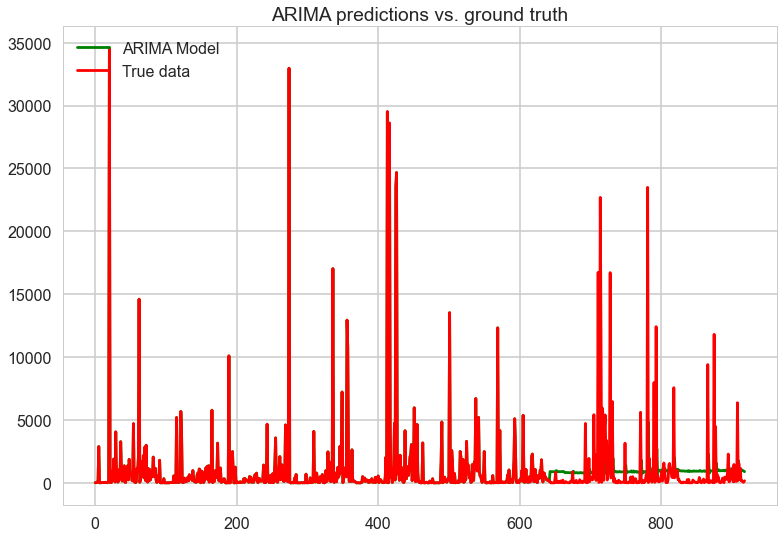

In [6]:

plot_time_series(ts_1=pred, ts_label_1='ARIMA Model', ts_2=time.radar[radar], ts_label_2='True data', title='ARIMA predictions vs. ground truth', path = '../figures/bird/%s.png'%radar)
